<a href="https://colab.research.google.com/github/solrepresa/RF-Valencia/blob/master/RF_valencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Random Forest con Apache Spark en Python.

Importantísimo! Instalar JAVA en Google Colab. El siguiente código instala Apache Spark 2.4.4, Java 8 y Findspark , una biblioteca que facilita a Python encontrar Spark.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

! java -version

openjdk version "11.0.6" 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)


Importamos las librerías que vamos a usar.
La mayoría son pyspark.

In [0]:
!pip install --upgrade pyspark

from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.context import SparkContext
from pyspark.sql.functions import col
from pyspark.sql.session import SparkSession


import pandas as pd
import numpy as np

     |████████████████████████████████| 217.8MB 59kB/s 
     |████████████████████████████████| 204kB 44.8MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=1734da6306b9fab07757537524bdb6ff847f4aae216c672908594d9186592c08
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [0]:
import findspark
findspark.init()

Creamos un contexto y sesión para Spark. Luego lo vamos a cerrar al final del código.

In [0]:
sc = SparkContext('local')
spark = SparkSession(sc)

Abrimos los datos. Es un 10% de mi dataset original. Está almacenado en github y lo traemos con una función de pandas. Una vez abierto en pandas el csv, lo convertimos al formato de dataFrame de Spark.


In [0]:
# URL datos
url = "https://raw.githubusercontent.com/solrepresa/RF-Valencia/master/prueba_datos.csv"
df1 = pd.read_csv(url)

In [0]:
type(df1)
data = spark.createDataFrame(df1)

In [0]:
type(data)

pyspark.sql.dataframe.DataFrame

In [0]:
#data = spark.read.format("csv").option("header", True).load("/variables_estacion_aod_IDW_modelo_paper.csv").option("delimiter", ",")

Verificamos que la tabla se encuentre cargada correctamente.

In [0]:
#display(data)
#data.show()
#data.describe().show()

data.show(10)
data.printSchema() #aparecen las variables como string?


+-----+------------------+-----+-----------+--------------------+----------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+------------------+-------------------+-------------------+------------------+-------------------+
| PM25|               DEM|CLC_1|         PS|                  RH|               T|                 U|                  V|             DUSMASS|             OCSMASS|            SO2SMASS|            SO4SMASS|             SSSMASS|             PBLH|             PRECTOT|             SPEED|             CLDHGH|             CLDLOW|             H1000|                AOD|
+-----+------------------+-----+-----------+--------------------+----------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-------

In [0]:
## Para cambiar el formato de las variables si hace falta.. 

# data = data.select(*(col(c).cast("double").alias(c) for c in data.columns))
# data.printSchema()
# data.show()

Calculamos estadísticos descriptivos de nuestro data set:

In [0]:
data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
PM25,98271,9.078298836557416,7.220148003122053,0.08,179.25
DEM,98271,220.12151786318375,266.2935849960927,1.531304,1107.88
CLC_1,98271,41.24941060944373,31.1262202042482,0.0,100.0
PS,98271,96130.37244601069,3640.7711304127947,86708.8,103669.0
RH,98271,0.3017333626834181,0.32683721664449855,6.596968000000002E-7,0.9999193999999999
T,98271,244.18034711201275,48.00726487158155,169.0197,309.2127
U,98271,-5.657127820578495,25.99961743328576,-107.7927,101.94617462158199
V,98271,1.6852785532081436,11.134694635419532,-62.98659,73.44799
DUSMASS,98271,1.402289795650405E-8,2.147794875956743E-8,1.8073370000000004E-21,4.7108020000000004E-7


**Nomeclatura en Machine Learning**:

* **Features**: Es el *input* del modelo. Es decir, las variables de entrada, predictoras o independientes del modelo. Se deben cargar como un vector donde se condensen todas las variables independientes. 

* **Labels**: Es el *output* del modelo. Es decir, la variable respuesta o dependiente.




Como primer paso en el armado del modelo, creamos una lista con los nombres de las variables que queremos ingresar al modelo. Como en nuestro caso son todas las columnas excepto la primera (PM25), hacemos un for que recorra el data set: 

In [0]:
feature_list = []
for col in data.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

In [0]:
#feature_list
feature_list = feature_list[1:25]

Para crear la columna FEATURES en data utilizamos la función **VectorAssembler()**. Por eso, aquí "features aparece como outputCol. Primero, creamos el modelo que nos permite transformar nuestros datos de entrada en una única columna y luego transformamos nuestros datos con la función *transform()*:

In [0]:
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

"A Pipeline consists with sequence of *Transformers* and *Estimators*. A Transformer is a ML Pipeline component that transforms a DataFrame into another DataFrame by using the **transform()** function. *StringIndexer*, *VectorAssembler* are the transformers in our pipeline. *Estimator* is the learning algorithm that trains the data. *Estimator* implements a method **fit()**, which accepts a DataFrame and produces a machine learning Model. *RandomForestClassifier* or *RandomForestRegression* is the estimator of the pipeline."

In [0]:
output = assembler.transform(data)

In [0]:
#output.printSchema()
output.show(10)
#output.select("features", "PM25").show(truncate=False)

+-----+------------------+-----+-----------+--------------------+----------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+------------------+-------------------+-------------------+------------------+-------------------+--------------------+
| PM25|               DEM|CLC_1|         PS|                  RH|               T|                 U|                  V|             DUSMASS|             OCSMASS|            SO2SMASS|            SO4SMASS|             SSSMASS|             PBLH|             PRECTOT|             SPEED|             CLDHGH|             CLDLOW|             H1000|                AOD|            features|
+-----+------------------+-----+-----------+--------------------+----------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----

Dividimos nuestros datos en un set de entrenamiento (80%) y otro de prueba (20%):

In [0]:
(trainingData, testData) = output.randomSplit([0.8, 0.2], seed = 132)

In [0]:
#type(trainingData)
#trainingData.printSchema()
#trainingData.take(10)

Creamos el modelo de regresión Random Forest con la función **RandomForestRegressor()**:

In [0]:
rf = RandomForestRegressor(labelCol="PM25", featuresCol="features", numTrees=100, seed= 123)

Haremos 2 cosas. Un modelo sin Cross Validation (cv) y otro con cv para comparar los resultados. 

A continuación, entrenamos el modelo SIN cv con la función **fit()**.

In [0]:
model = rf.fit(trainingData)

Podemos saber cuál variables predictora tiene mayor peso con **.featureImportance**:

In [0]:
model.featureImportances


SparseVector(19, {0: 0.1108, 1: 0.0357, 2: 0.0022, 3: 0.0043, 4: 0.0005, 5: 0.0054, 6: 0.001, 7: 0.1609, 8: 0.1959, 9: 0.087, 10: 0.046, 11: 0.0107, 12: 0.0158, 13: 0.0027, 14: 0.0272, 15: 0.0046, 16: 0.0126, 17: 0.0253, 18: 0.2513})

In [0]:
feature_list[0],feature_list [7],feature_list[8], feature_list[18]

('DEM', 'DUSMASS', 'OCSMASS', 'AOD')

In [0]:
## No termino de entender para que sirve Pipeline()
 
#pipeline = Pipeline(assembler)
#pipeline_model = pipeline.fit(trainingData)
#pipeline_prediction = pipeline_model.transform(testData)
#pipeline_prediction.show(10)

Para aplicar el Cross Validation es necesario que 1) creeemos una grilla, la cual servirá para fraccionar los datos de nuestro set de entrenamiento, y 2) definamos cómo se evaluará la regresión. Lo primero lo haremos con la función **ParamGrudBuilder()**

In [0]:
paramGrid = ParamGridBuilder().build()
    #.addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]) \
    #.addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 10)]) \


y lo segundo con la función **RegressionEvaluator()**:

In [0]:
rf_evaluator = RegressionEvaluator(predictionCol="PM25", labelCol="PM25", metricName="rmse")

Finalmente, armamos el Cross Validation con todas las partes anteriores. La función utilizada es **CrossValidator()**

In [0]:
crossval = CrossValidator(estimator = rf, #el modelo
                          estimatorParamMaps = paramGrid, #la grilla
                          evaluator = rf_evaluator, #la evaluacion
                          numFolds = 10,
                          seed=123)

La variables obtenida de *CrossValidator()* es nuestro "nuevo" modelo. Por tanto, lo entrenaremos con **fit()** como hicimos antes:

In [0]:
cvModel = crossval.fit(trainingData) # train: DataFrame
#print(cvModel)

CrossValidatorModel_b202e0afd9c6


[0.0]

In [0]:
cvModel.avgMetrics # Solo para cross validation

In [0]:
cvModel.bestModel

RandomForestRegressionModel (uid=RandomForestRegressor_0852092bc3d3) with 100 trees

Finalmente, generamos las predicciones del modelo con la función **transform()**. Esto lo haremos para los 2 modelos (con y sin CV).

In [0]:
predictions = model.transform(testData)
predictions_cv = cvModel.transform(testData)

In [0]:
#predictions.show(10)

Evaluamos las predicciones de los modelos. Para ello, podemos utilizar una serie de medidas del error.

In [0]:
eval = RegressionEvaluator(labelCol="PM25", predictionCol="prediction", metricName="rmse")

print("Modelo RF sin CV")
# Root Mean Square Error
rmse = eval.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: %.3f" % rmse)

# Mean Square Error
mse = eval.evaluate(predictions, {eval.metricName: "mse"})
print("Mean Square Error (MSE) on test data: %.3f" % mse)

# Mean Absolute Error
mae = eval.evaluate(predictions, {eval.metricName: "mae"})
print("Mean Absolute Error (MAE) on test data: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(predictions, {eval.metricName: "r2"})
print("R Squared (R2) on test data: %.3f" %r2)

Modelo RF sin CV
Root Mean Squared Error (RMSE) on test data: 6.188
Mean Square Error (MSE) on test data: 38.286
Mean Absolute Error (MAE) on test data: 4.221
R Squared (R2) on test data: 0.253


In [0]:
eval = RegressionEvaluator(labelCol="PM25", predictionCol="prediction", metricName="rmse")

print("Modelo RF con CV")
# Root Mean Square Error
rmse = eval.evaluate(predictions_cv)
print("Root Mean Squared Error (RMSE) on test data: %.3f" % rmse)

# Mean Square Error
mse = eval.evaluate(predictions_cv, {eval.metricName: "mse"})
print("Mean Square Error (MSE) on test data: %.3f" % mse)

# Mean Absolute Error
mae = eval.evaluate(predictions_cv, {eval.metricName: "mae"})
print("Mean Absolute Error (MAE) on test data: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(predictions_cv, {eval.metricName: "r2"})
print("R Squared (R2) on test data: %.3f" %r2)

Modelo RF con CV
Root Mean Squared Error (RMSE) on test data: 6.188
Mean Square Error (MSE) on test data: 38.286
Mean Absolute Error (MAE) on test data: 4.221
R Squared (R2) on test data: 0.253


Gráficamos las predicciones. Para ello es necesario convertir los datos del formato de Spark a Pandas con la función **toPandas()**:

In [0]:
rfResult = predictions.toPandas()
#rfResult.head()

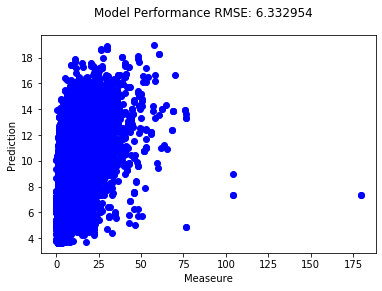

In [0]:
import matplotlib.pyplot as plt
plt.plot(rfResult.PM25, rfResult.prediction, 'bo')
plt.xlabel('Measeure')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Text(0.5, 1.0, 'Feature Importances')

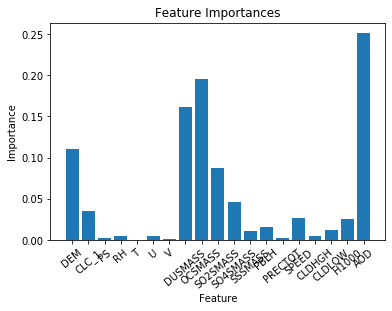

In [0]:
### VER ESTO ###
# bestPipeline = model.bestModel
# bestModel = bestPipeline.stages[1]

importances = model.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [0]:
print('numTrees - ', model.getNumTrees)
print('maxDepth - ', model.getOrDefault('maxDepth'))

numTrees -  100
maxDepth -  5


Guardamos el modelo:

In [0]:
# Guardar modelo
# cvModel.write.overwrite().save("/model")
  
# CrossValidatorModel model here 
# cvModelLoaded = CrossValidatorModel.load("/model")

Cerramos la sesión:

In [0]:
sc.stop()